<a href="https://colab.research.google.com/github/Hashyyy2005/multi-obj-VRP-solver/blob/main/multi_objective_vrp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:


import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

# --- 1. Realistic Data Generation ---
NUM_CUSTOMERS = 50
MAP_SIZE = 100
NUM_CLUSTERS = 4
CUSTOMERS_PER_CLUSTER = NUM_CUSTOMERS // NUM_CLUSTERS
VIP_PERCENTAGE = 0.2
np.random.seed(42)

all_customers = []
cluster_centers = np.random.rand(NUM_CLUSTERS, 2) * MAP_SIZE
for i in range(NUM_CLUSTERS):
    x_coords = np.clip(np.random.randn(CUSTOMERS_PER_CLUSTER) * (MAP_SIZE / 10) + cluster_centers[i, 0], 0, MAP_SIZE)
    y_coords = np.clip(np.random.randn(CUSTOMERS_PER_CLUSTER) * (MAP_SIZE / 10) + cluster_centers[i, 1], 0, MAP_SIZE)
    for j in range(CUSTOMERS_PER_CLUSTER):
        all_customers.append({'X': x_coords[j], 'Y': y_coords[j]})

locations_df = pd.DataFrame(all_customers)
depot_df = pd.DataFrame([{'ID': 0, 'X': MAP_SIZE / 2, 'Y': MAP_SIZE / 2, 'Priority': 'Depot'}])
customers_df = locations_df.copy()
customers_df['ID'] = range(1, len(customers_df) + 1)
customers_df['Priority'] = 'Standard'
num_vips = int(len(customers_df) * VIP_PERCENTAGE)
vip_indices = np.random.choice(customers_df.index, size=num_vips, replace=False)
customers_df.loc[vip_indices, 'Priority'] = 'VIP'
final_locations_df = pd.concat([depot_df, customers_df[['ID', 'X', 'Y', 'Priority']]], ignore_index=True)

vehicles_data = {'VehicleType': ['Gas', 'Electric'], 'CO2_per_km': [0.2, 0.05]}
vehicles_df = pd.DataFrame(vehicles_data)

final_locations_df.to_csv('multi_obj_locations.csv', index=False)
vehicles_df.to_csv('multi_obj_vehicles.csv', index=False)
print("--- New, Realistic VRP Datasets Generated ---")


# --- 2. Data Preparation for Efficient Lookups ---
location_map = {row.ID: (row.X, row.Y) for index, row in final_locations_df.iterrows()}
customer_priority_map = {row.ID: row.Priority for index, row in final_locations_df.iterrows()}
co2_factors_map = {row.VehicleType: row.CO2_per_km for index, row in vehicles_df.iterrows()}


# --- 3. Core Utility - Distance Calculator (CORRECTED) ---
def calculate_distance(point1, point2):
    """Calculates the Euclidean distance between two points given as (x, y) tuples."""
    # CORRECTED LOGIC: Uses point2[1] in the second term.
    return np.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)

print("\n--- Foundation is built and CORRECTED. Ready for analysis. ---")

--- New, Realistic VRP Datasets Generated ---

--- Foundation is built and CORRECTED. Ready for analysis. ---


In [2]:
# ==============================================================================
# FINALIZED OBJECTIVE FUNCTIONS & BASELINE
# ==============================================================================

# --- The Three Objective Functions ---
def calculate_total_cost(route, location_map):
    if not route: return 0
    total_distance = 0
    depot_location = location_map[0]
    first_customer_location = location_map[route[0]]
    total_distance += calculate_distance(depot_location, first_customer_location)
    for i in range(len(route) - 1):
        from_location = location_map[route[i]]
        to_location = location_map[route[i+1]]
        total_distance += calculate_distance(from_location, to_location)
    last_customer_location = location_map[route[-1]]
    total_distance += calculate_distance(last_customer_location, depot_location)
    return total_distance

def calculate_total_emissions(route, vehicle_type, location_map, co2_factors_map):
    total_distance = calculate_total_cost(route, location_map)
    emission_factor = co2_factors_map.get(vehicle_type, 0)
    return total_distance * emission_factor

def calculate_vip_lateness(route, location_map, customer_priority_map):
    last_vip_index = -1
    for i, customer_id in enumerate(route):
        if customer_priority_map.get(customer_id) == 'VIP':
            last_vip_index = i
    if last_vip_index == -1: return 0
    sub_route_to_last_vip = route[0 : last_vip_index + 1]
    lateness_distance = 0
    current_location = location_map[0]
    for customer_id in sub_route_to_last_vip:
        next_location = location_map[customer_id]
        lateness_distance += calculate_distance(current_location, next_location)
        current_location = next_location
    return lateness_distance


# --- Verification Test ---
print("--- Running Verification Test ---")
all_customer_ids = list(final_locations_df[final_locations_df.ID != 0].ID)
sample_route = random.sample(all_customer_ids, len(all_customer_ids))
sample_vehicle_type = 'Gas'

cost_score = calculate_total_cost(sample_route, location_map)
emission_score = calculate_total_emissions(sample_route, sample_vehicle_type, location_map, co2_factors_map)
lateness_score = calculate_vip_lateness(sample_route, location_map, customer_priority_map)

print(f"Test complete for a sample route with a '{sample_vehicle_type}' vehicle.")
print(f" -> Economic Cost (Distance): {cost_score:.2f}")
print(f" -> Environmental Impact (CO2): {emission_score:.2f} kg")
print(f" -> Service Level (VIP Lateness): {lateness_score:.2f}")
print("--- Verification Finished ---")


# --- BASELINE MODEL: NEAREST NEIGHBOR HEURISTIC ---
def solve_with_nearest_neighbor(customer_ids, location_map):
    unvisited = customer_ids.copy()
    current_id = 0
    route = []
    while unvisited:
        closest_dist = float('inf')
        closest_id = None
        for next_id in unvisited:
            dist = calculate_distance(location_map[current_id], location_map[next_id])
            if dist < closest_dist:
                closest_dist = dist
                closest_id = next_id
        route.append(closest_id)
        unvisited.remove(closest_id)
        current_id = closest_id
    return route

print("\n--- Running Baseline Heuristic (Nearest Neighbor) ---")
baseline_route = solve_with_nearest_neighbor(all_customer_ids, location_map)
baseline_distance = calculate_total_cost(baseline_route, location_map)

print(f"Baseline Route Distance: {baseline_distance:.2f}")
print("--- Baseline Complete ---")

--- Running Verification Test ---
Test complete for a sample route with a 'Gas' vehicle.
 -> Economic Cost (Distance): 2157.31
 -> Environmental Impact (CO2): 431.46 kg
 -> Service Level (VIP Lateness): 1954.20
--- Verification Finished ---

--- Running Baseline Heuristic (Nearest Neighbor) ---
Baseline Route Distance: 570.16
--- Baseline Complete ---


In [3]:
# ==============================================================================
# NSGA-II ENGINE: THE CORE OPTIMIZER LOGIC
# ==============================================================================
# This block contains the specialized functions for multi-objective selection.

# --- 1. The "Dominates" Function (The Core Comparison) ---
# This is a precise, low-level function with no room for ambiguity.
def dominates(scores1, scores2):
    """
    Checks if solution 1 (scores1) dominates solution 2 (scores2).
    A solution dominates if it is AT LEAST as good on all objectives,
    AND strictly better on AT LEAST ONE objective.
    (Assumes LOWER scores are BETTER for all objectives).
    """
    # Check if scores1 is worse than scores2 on any objective. If so, it can't dominate.
    if any(s1 > s2 for s1, s2 in zip(scores1, scores2)):
        return False

    # Check if scores1 is strictly better on at least one objective.
    if any(s1 < s2 for s1, s2 in zip(scores1, scores2)):
        return True

    return False

# --- 2. The "Fast Non-Dominated Sort" Function (The Ranking Engine) ---
# This is the heart of NSGA-II. It's complex, so comments are critical.
def fast_non_dominated_sort(population_scores):
    """
    Sorts a population into fronts based on non-domination.
    Input: A list of scores, e.g., [[cost1, co2_1, late1], [cost2, co2_2, late2], ...]
    Output: A list of fronts, where each front is a list of INDICES of the individuals.
    """
    # S[p] will be a list of solutions that solution 'p' dominates.
    S = [[] for _ in range(len(population_scores))]

    # n[p] will be the number of solutions that dominate solution 'p'.
    n = [0] * len(population_scores)

    # The list of fronts. front[0] is the first (best) front.
    fronts = [[]]

    # --- First pass: Compare every solution with every other solution ---
    for p_idx, p_scores in enumerate(population_scores):
        for q_idx, q_scores in enumerate(population_scores):
            if p_idx == q_idx:
                continue

            if dominates(p_scores, q_scores):
                # If p dominates q, add q to the list of solutions dominated by p.
                S[p_idx].append(q_idx)
            elif dominates(q_scores, p_scores):
                # If q dominates p, increment the domination counter of p.
                n[p_idx] += 1

        # If no solutions dominate p, then p is in the first front.
        if n[p_idx] == 0:
            fronts[0].append(p_idx)

    # --- Build the subsequent fronts ---
    i = 0
    while fronts[i]:
        # Create the next front
        next_front = []
        # For each individual p in the current front...
        for p_idx in fronts[i]:
            # Look at all individuals q that p dominates...
            for q_idx in S[p_idx]:
                # Decrement the domination counter of q.
                n[q_idx] -= 1
                # If q's domination counter is now 0, it belongs to the next front.
                if n[q_idx] == 0:
                    next_front.append(q_idx)

        i += 1
        # Append the newly created front to the list of fronts.
        fronts.append(next_front)

    # Return all fronts, removing the last empty one.
    return fronts[:-1]

# --- 3. The "Crowding Distance" Function (The Diversity Engine) ---
def calculate_crowding_distance(front_scores):
    """
    Calculates the crowding distance for each solution in a single front.
    Input: A list of scores for individuals in ONE front.
    Output: A dictionary of {index: distance}.
    """
    num_solutions = len(front_scores)
    if num_solutions == 0:
        return {}

    # Initialize distances to zero.
    distances = {i: 0.0 for i in range(num_solutions)}
    num_objectives = len(front_scores[0])

    for m in range(num_objectives):
        # Sort the front based on the m-th objective score.
        # We store the original index to update the correct distance later.
        sorted_front = sorted(enumerate(front_scores), key=lambda x: x[1][m])

        # The solutions at the ends of the sorted list (boundaries) are given infinite distance.
        # This ensures they are always preserved.
        distances[sorted_front[0][0]] = float('inf')
        distances[sorted_front[-1][0]] = float('inf')

        # Get the min and max scores for this objective to normalize.
        min_score = sorted_front[0][1][m]
        max_score = sorted_front[-1][1][m]

        # Avoid division by zero if all scores are the same.
        if max_score == min_score:
            continue

        # For all other solutions, calculate the distance.
        for i in range(1, num_solutions - 1):
            original_index = sorted_front[i][0]
            prev_score = sorted_front[i-1][1][m]
            next_score = sorted_front[i+1][1][m]

            # Distance = normalized difference between neighbors
            distances[original_index] += (next_score - prev_score) / (max_score - min_score)

    return distances

print("--- NSGA-II Engine Components Defined and Ready ---")

--- NSGA-II Engine Components Defined and Ready ---


--- Starting NSGA-II Multi-Objective Optimization ---
Population Size: 100, Generations: 500
Generation 50/500 | Best Cost: 1075.12 | Best Emissions: 215.02 | Best Lateness: 417.92
Generation 100/500 | Best Cost: 1061.36 | Best Emissions: 212.27 | Best Lateness: 244.40
Generation 150/500 | Best Cost: 1003.79 | Best Emissions: 200.76 | Best Lateness: 439.60
Generation 200/500 | Best Cost: 1128.19 | Best Emissions: 225.64 | Best Lateness: 515.85
Generation 250/500 | Best Cost: 863.74 | Best Emissions: 172.75 | Best Lateness: 511.09
Generation 300/500 | Best Cost: 959.90 | Best Emissions: 191.98 | Best Lateness: 500.58
Generation 350/500 | Best Cost: 1065.06 | Best Emissions: 213.01 | Best Lateness: 487.51
Generation 400/500 | Best Cost: 1192.14 | Best Emissions: 238.43 | Best Lateness: 607.94
Generation 450/500 | Best Cost: 849.36 | Best Emissions: 169.87 | Best Lateness: 611.78
Generation 500/500 | Best Cost: 879.17 | Best Emissions: 175.83 | Best Lateness: 508.49

--- NSGA-II Optimizat

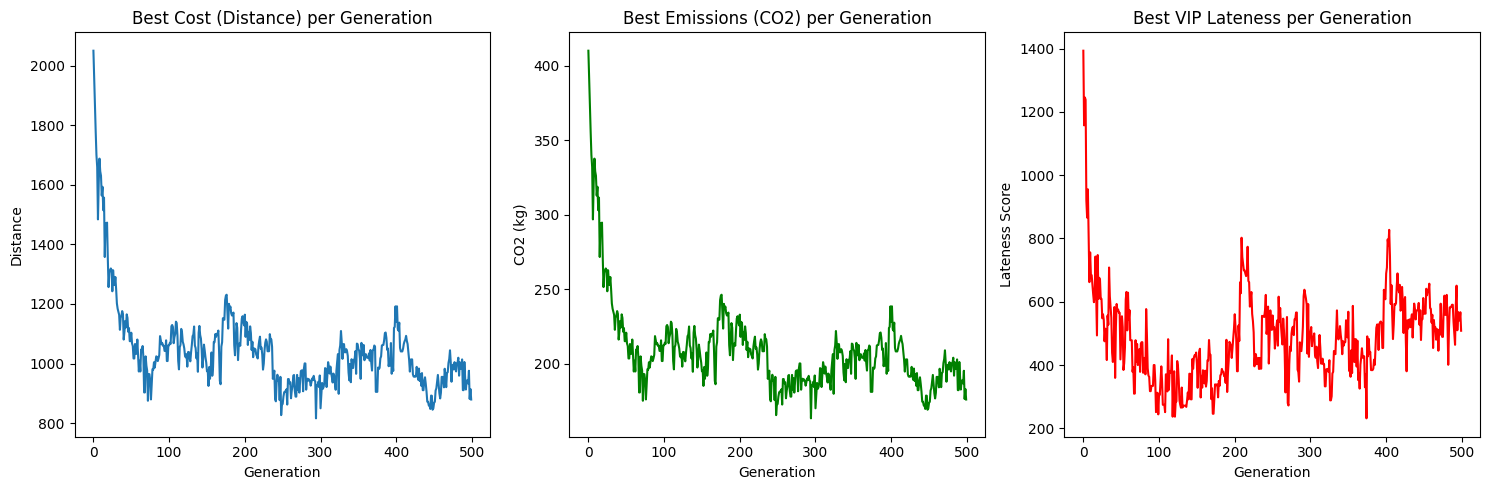

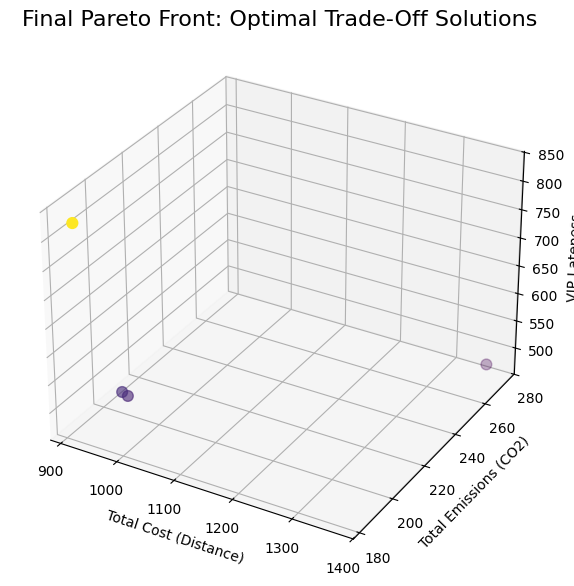

In [4]:


# --- Helper Functions for Genetic Operations (Moved Here) ---

def create_initial_population(population_size, customer_ids):
    """
    Generates a list of random permutations of customer_ids as the initial population.
    """
    population = []
    for _ in range(population_size):
        # Create a random permutation of the customer IDs
        route = random.sample(customer_ids, len(customer_ids))
        population.append(route)
    return population

def calculate_all_objectives(route, vehicle_type, location_map, co2_factors_map, customer_priority_map):
    """
    Calculates all three objective scores for a single route.
    Returns a tuple of (cost, emissions, lateness).
    """
    cost = calculate_total_cost(route, location_map)
    emissions = calculate_total_emissions(route, vehicle_type, location_map, co2_factors_map)
    lateness = calculate_vip_lateness(route, location_map, customer_priority_map)
    return (cost, emissions, lateness)

def ordered_crossover(parent1, parent2):
    """
    Performs Ordered Crossover (OX1) between two parent routes.
    Ensures that each customer is visited exactly once in the child route.
    """
    size = len(parent1)
    child = [None] * size

    # 1. Choose a random sub-section (crossover points)
    start, end = sorted(random.sample(range(size), 2))

    # 2. Copy the sub-section from parent1 to the child
    child[start:end+1] = parent1[start:end+1]

    # 3. Fill the remaining positions from parent2, maintaining order and avoiding duplicates
    parent2_sequence = []
    # Build a sequence from parent2 that excludes customers already in the child
    for customer_id in parent2:
        if customer_id not in child:
            parent2_sequence.append(customer_id)

    # Insert the remaining customers into the child starting after the copied section,
    # wrapping around if necessary.
    current_parent2_idx = 0
    for i in range(size):
        # Calculate the position in the child, wrapping around using modulo
        child_idx = (end + 1 + i) % size
        # If this position in the child is empty, fill it with the next customer from parent2_sequence
        if child[child_idx] is None:
            child[child_idx] = parent2_sequence[current_parent2_idx]
            current_parent2_idx += 1

    return child

def swap_mutation(route, mutation_rate):
    """
    Applies swap mutation to a route with a given probability.
    Randomly swaps two customer positions if the mutation occurs.
    """
    mutated_route = route.copy()
    if random.random() < mutation_rate:
        # Choose two random indices (positions in the route)
        idx1, idx2 = random.sample(range(len(mutated_route)), 2)
        # Swap the customers at these positions
        mutated_route[idx1], mutated_route[idx2] = mutated_route[idx2], mutated_route[idx1]
    return mutated_route


# --- 1. Hyperparameters (The Control Knobs) ---
# These are the settings we can tune to change the algorithm's behavior.
POPULATION_SIZE = 100
NUM_GENERATIONS = 500
MUTATION_RATE = 0.05
TOURNAMENT_SIZE = 5
# We assume a 'Gas' vehicle for this entire run for simplicity.
VEHICLE_TYPE = 'Gas'

# --- 2. Initialization ---
# Create a list of all customer IDs (excluding the depot)
all_customer_ids = list(final_locations_df[final_locations_df.ID != 0].ID)
# Create our starting population of random routes
population = create_initial_population(POPULATION_SIZE, all_customer_ids)

# Lists to store the progress of our optimization for later plotting
progress_cost = []
progress_emissions = []
progress_lateness = []


print("--- Starting NSGA-II Multi-Objective Optimization ---")
print(f"Population Size: {POPULATION_SIZE}, Generations: {NUM_GENERATIONS}")

# --- 3. The Main Evolutionary Loop ---
for generation in range(NUM_GENERATIONS):
    # --- a. Evaluation ---
    # Calculate the three objective scores for every individual in the current population.
    all_scores = [calculate_all_objectives(ind, VEHICLE_TYPE, location_map, co2_factors_map, customer_priority_map) for ind in population]

    # --- b. Ranking (Using our NSGA-II Engine) ---
    # This is the core ranking step. It gives us our fronts.
    fronts = fast_non_dominated_sort(all_scores)

    # Store the best front for tracking progress
    # The scores of the best solutions are in the first front.
    best_front_scores = [all_scores[i] for i in fronts[0]]
    # We will track the "best" as the one with the lowest cost in the best front
    best_cost_in_gen = min(s[0] for s in best_front_scores)
    best_emissions_in_gen = min(s[1] for s in best_front_scores)
    best_lateness_in_gen = min(s[2] for s in best_front_scores)
    progress_cost.append(best_cost_in_gen)
    progress_emissions.append(best_emissions_in_gen)
    progress_lateness.append(best_lateness_in_gen)

    # --- c. Selection (Building the Mating Pool) ---
    # This is where we will add our "creative specialization".
    mating_pool = []

    # Iterate through the fronts, starting from the best (Front 0)
    for front in fronts:
        # Get the scores of the individuals in this front
        front_scores_for_crowding = [all_scores[i] for i in front]
        # Calculate crowding distance for this front
        crowding_distances = calculate_crowding_distance(front_scores_for_crowding)

        # We need to map the crowding distances back to the original population indices
        front_indices_with_distances = {original_idx: crowding_distances[front_idx] for front_idx, original_idx in enumerate(front)}

        # Add individuals to the mating pool until it's full (half the population size)
        for idx in front:
            if len(mating_pool) < POPULATION_SIZE:
                # *** THE CREATIVE SPECIALIZATION ***
                # Instead of a simple tournament, our selection is now based on two criteria:
                # 1. Front Number (Primary): Better front is always better.
                # 2. Crowding Distance (Secondary): More unique (less crowded) is better.
                # We add both the individual and their rank/diversity score to the pool.
                mating_pool.append({
                    'individual': population[idx],
                    'front': fronts.index(front),
                    'crowding_distance': front_indices_with_distances[idx]
                })
        if len(mating_pool) >= POPULATION_SIZE:
            break # Stop once the pool is full

    # --- d. Crossover & Mutation (Creating the New Generation) ---
    new_population = []
    for _ in range(POPULATION_SIZE // 2):
        # Select two parents from the mating pool using a tournament
        # that considers both rank and crowding distance.
        parent1_data = min(random.sample(mating_pool, TOURNAMENT_SIZE), key=lambda x: (x['front'], -x['crowding_distance']))
        parent2_data = min(random.sample(mating_pool, TOURNAMENT_SIZE), key=lambda x: (x['front'], -x['crowding_distance']))

        parent1 = parent1_data['individual']
        parent2 = parent2_data['individual']

        child1 = ordered_crossover(parent1, parent2)
        child2 = ordered_crossover(parent2, parent1)

        new_population.append(swap_mutation(child1, MUTATION_RATE))
        new_population.append(swap_mutation(child2, MUTATION_RATE))

    # Replace the old population with the new generation of children
    population = new_population

    # Print progress
    if (generation + 1) % 50 == 0:
        print(f"Generation {generation + 1}/{NUM_GENERATIONS} | Best Cost: {best_cost_in_gen:.2f} | Best Emissions: {best_emissions_in_gen:.2f} | Best Lateness: {best_lateness_in_gen:.2f}")


# --- 4. Final Results ---
print("\n--- NSGA-II Optimization Finished ---")
final_scores = [calculate_all_objectives(ind, VEHICLE_TYPE, location_map, co2_factors_map, customer_priority_map) for ind in population]
final_fronts = fast_non_dominated_sort(final_scores)

# The final set of optimal solutions is the first front
best_solutions_indices = final_fronts[0]
best_solutions_scores = [final_scores[i] for i in best_solutions_indices]

print(f"Found {len(best_solutions_scores)} optimal trade-off solutions (the Pareto Front).")

# --- 5. Plotting and Visualization ---
# Plot the progress of the optimization
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(progress_cost)
plt.title("Best Cost (Distance) per Generation")
plt.xlabel("Generation")
plt.ylabel("Distance")

plt.subplot(1, 3, 2)
plt.plot(progress_emissions, color='green')
plt.title("Best Emissions (CO2) per Generation")
plt.xlabel("Generation")
plt.ylabel("CO2 (kg)")

plt.subplot(1, 3, 3)
plt.plot(progress_lateness, color='red')
plt.title("Best VIP Lateness per Generation")
plt.xlabel("Generation")
plt.ylabel("Lateness Score")
plt.tight_layout()
plt.show()

# Plot the final Pareto Front
plt.figure(figsize=(10, 7))
costs = [s[0] for s in best_solutions_scores]
emissions = [s[1] for s in best_solutions_scores]
latenesses = [s[2] for s in best_solutions_scores]

ax = plt.axes(projection='3d')
ax.scatter3D(costs, emissions, latenesses, c=latenesses, cmap='viridis', s=60)
ax.set_xlabel('Total Cost (Distance)')
ax.set_ylabel('Total Emissions (CO2)')
ax.set_zlabel('VIP Lateness')
ax.set_title('Final Pareto Front: Optimal Trade-Off Solutions', fontsize=16)
plt.show()

--- Preparing to Plot the Optimal Route Solutions with Gradient Coloring ---
Found 4 solutions to visualize.


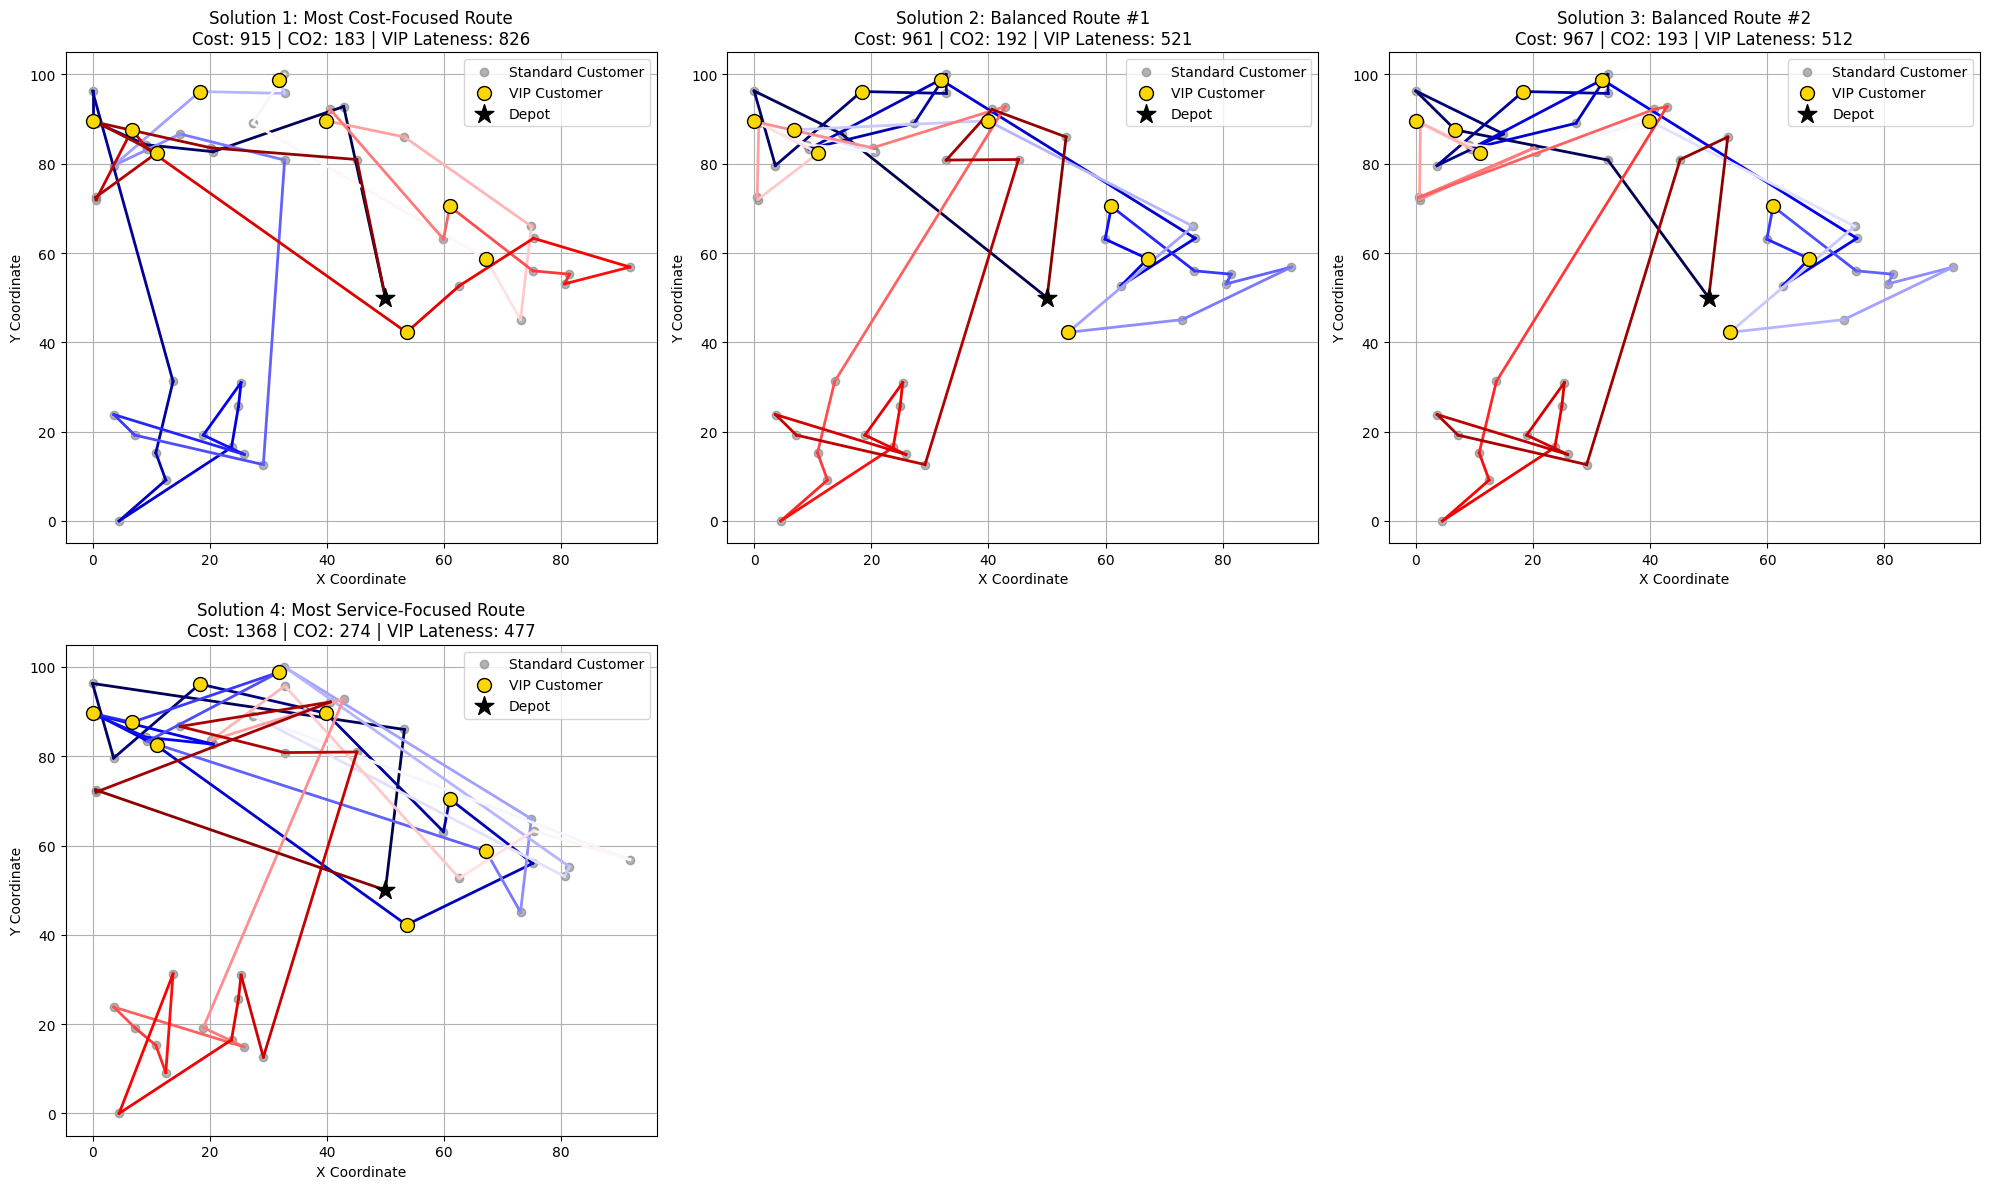

In [5]:
# ==============================================================================
# UPGRADED VISUALIZATION OF THE FINAL PARETO FRONT SOLUTIONS (WITH GRADIENT ROUTES)
# ==============================================================================

print("--- Preparing to Plot the Optimal Route Solutions with Gradient Coloring ---")

# --- Step 1: Aggregate the Final Solutions (No Change) ---
best_solution_indices = final_fronts[0]
pareto_solutions = []
for index in best_solution_indices:
    pareto_solutions.append({
        'route': population[index],
        'scores': final_scores[index]
    })
pareto_solutions.sort(key=lambda x: x['scores'][0])
print(f"Found {len(pareto_solutions)} solutions to visualize.")

# --- Step 2: Prepare Background Plotting Data (No Change) ---
depot_coords = location_map[0]
standard_customers = [location_map[cid] for cid, prio in customer_priority_map.items() if prio == 'Standard']
vip_customers = [location_map[cid] for cid, prio in customer_priority_map.items() if prio == 'VIP']
std_x, std_y = zip(*standard_customers) if standard_customers else ([], [])
vip_x, vip_y = zip(*vip_customers) if vip_customers else ([], [])

# --- Step 3: Create the Subplots with Gradient Route Lines (THE UPGRADE) ---
num_solutions = len(pareto_solutions)
num_cols = 3
num_rows = (num_solutions + num_cols - 1) // num_cols
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 6 * num_rows))
axes = axes.flatten()

# --- THE NEW PART: Define the color gradient ---
# We will use a Matplotlib colormap. 'seismic' goes from Blue to White to Red.
# 'viridis' goes from Purple to Green to Yellow. Let's use seismic as it matches your idea.
colormap = plt.cm.seismic

for i, solution_data in enumerate(pareto_solutions):
    ax = axes[i]

    # --- a. Plot the background locations (No Change) ---
    ax.scatter(std_x, std_y, c='grey', alpha=0.6, label='Standard Customer')
    ax.scatter(vip_x, vip_y, c='gold', s=100, edgecolor='black', label='VIP Customer', zorder=5)
    ax.scatter(depot_coords[0], depot_coords[1], c='black', marker='*', s=200, label='Depot', zorder=10)

    # --- b. Plot the route for this specific solution SEGMENT BY SEGMENT ---
    route = solution_data['route']
    full_tour_ids = [0] + route + [0]
    num_segments = len(full_tour_ids) - 1

    # Loop through each segment of the tour (e.g., Depot to C1, C1 to C2, etc.)
    for j in range(num_segments):
        # Get the start and end points of the current segment
        start_node_id = full_tour_ids[j]
        end_node_id = full_tour_ids[j+1]

        start_coords = location_map[start_node_id]
        end_coords = location_map[end_node_id]

        # Calculate the color for this segment based on its position in the tour
        # The value 'j / num_segments' will go from 0.0 (start) to 1.0 (end).
        # The colormap will translate this number into a specific color.
        segment_color = colormap(j / num_segments)

        # Draw just this one segment
        ax.plot([start_coords[0], end_coords[0]], [start_coords[1], end_coords[1]],
                color=segment_color, linewidth=2)

    # --- c. Add an informative title (No Change) ---
    scores = solution_data['scores']
    cost, emissions, lateness = scores
    title_label = "Route"
    if i == 0: title_label = "Most Cost-Focused Route"
    elif i == len(pareto_solutions) -1 : title_label = "Most Service-Focused Route"
    else: title_label = f"Balanced Route #{i}"

    ax.set_title(
        f"Solution {i+1}: {title_label}\n"
        f"Cost: {cost:.0f} | CO2: {emissions:.0f} | VIP Lateness: {lateness:.0f}",
        fontsize=12
    )

    ax.set_xlabel("X Coordinate")
    ax.set_ylabel("Y Coordinate")
    ax.legend()
    ax.grid(True)

# Hide any unused subplots
for j in range(num_solutions, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

In [6]:
# ==============================================================================
# NSGA-II: Helper Functions for Genetic Operations
# ==============================================================================

# --- 1. Initial Population Creation ---
def create_initial_population(population_size, customer_ids):
    """
    Generates a list of random permutations of customer_ids as the initial population.
    """
    population = []
    for _ in range(population_size):
        # Create a random permutation of the customer IDs
        route = random.sample(customer_ids, len(customer_ids))
        population.append(route)
    return population

# --- 2. Combined Objective Calculation ---
def calculate_all_objectives(route, vehicle_type, location_map, co2_factors_map, customer_priority_map):
    """
    Calculates all three objective scores for a single route.
    Returns a tuple of (cost, emissions, lateness).
    """
    cost = calculate_total_cost(route, location_map)
    emissions = calculate_total_emissions(route, vehicle_type, location_map, co2_factors_map)
    lateness = calculate_vip_lateness(route, location_map, customer_priority_map)
    return (cost, emissions, lateness)

# --- 3. Ordered Crossover (OX1) ---
def ordered_crossover(parent1, parent2):
    """
    Performs Ordered Crossover (OX1) between two parent routes.
    Ensures that each customer is visited exactly once in the child route.
    """
    size = len(parent1)
    child = [None] * size

    # 1. Choose a random sub-section (crossover points)
    start, end = sorted(random.sample(range(size), 2))

    # 2. Copy the sub-section from parent1 to the child
    child[start:end+1] = parent1[start:end+1]

    # 3. Fill the remaining positions from parent2, maintaining order and avoiding duplicates
    parent2_sequence = []
    # Build a sequence from parent2 that excludes customers already in the child
    for customer_id in parent2:
        if customer_id not in child:
            parent2_sequence.append(customer_id)

    # Insert the remaining customers into the child starting after the copied section,
    # wrapping around if necessary.
    current_parent2_idx = 0
    for i in range(size):
        # Calculate the position in the child, wrapping around using modulo
        child_idx = (end + 1 + i) % size
        # If this position in the child is empty, fill it with the next customer from parent2_sequence
        if child[child_idx] is None:
            child[child_idx] = parent2_sequence[current_parent2_idx]
            current_parent2_idx += 1

    return child

# --- 4. Swap Mutation ---
def swap_mutation(route, mutation_rate):
    """
    Applies swap mutation to a route with a given probability.
    Randomly swaps two customer positions if the mutation occurs.
    """
    mutated_route = route.copy()
    if random.random() < mutation_rate:
        # Choose two random indices (positions in the route)
        idx1, idx2 = random.sample(range(len(mutated_route)), 2)
        # Swap the customers at these positions
        mutated_route[idx1], mutated_route[idx2] = mutated_route[idx2], mutated_route[idx1]
    return mutated_route

print("--- NSGA-II Helper Functions Defined ---")

--- NSGA-II Helper Functions Defined ---


In [7]:
# ==============================================================================
# MODULE 2: ADAPTIVE LARGE NEIGHBORHOOD SEARCH (ALNS) ENGINE
# This is our new "Local Improver" to super-charge our Genetic Algorithm.
# ==============================================================================

# --- 1. The "Destroy" Toolbox ---

def destroy_random(route, percentage_to_destroy):
    """
    Removes a random percentage of customers from the route.
    Returns: a partial route and a list of the removed ("unrouted") customers.
    """
    num_to_remove = int(len(route) * percentage_to_destroy)

    # Randomly choose which customer indices to remove
    indices_to_remove = random.sample(range(len(route)), num_to_remove)

    # Sort indices in reverse order to avoid index shifting issues during removal
    indices_to_remove.sort(reverse=True)

    unrouted_customers = []
    partial_route = route.copy()

    for index in indices_to_remove:
        # pop() removes the item at the index and returns it
        unrouted_customers.append(partial_route.pop(index))

    return partial_route, unrouted_customers

def destroy_worst(route, percentage_to_destroy, location_map):
    """
    Removes the most "expensive" customers from a route.
    "Expensive" is defined by the extra distance a customer adds to the tour.
    """
    num_to_remove = int(len(route) * percentage_to_destroy)

    # Calculate the cost contribution of each customer in the route
    costs = []
    full_tour_ids = [0] + route + [0]
    for i in range(1, len(full_tour_ids) - 1):
        prev_node = full_tour_ids[i-1]
        current_node = full_tour_ids[i]
        next_node = full_tour_ids[i+1]

        # Cost = dist(prev->curr) + dist(curr->next) - dist(prev->next)
        cost_contribution = (calculate_distance(location_map[prev_node], location_map[current_node]) +
                             calculate_distance(location_map[current_node], location_map[next_node]) -
                             calculate_distance(location_map[prev_node], location_map[next_node]))
        costs.append((cost_contribution, route[i-1])) # Store as (cost, customer_id)

    # Sort customers by their cost contribution in descending order
    costs.sort(reverse=True, key=lambda x: x[0])

    # Get the IDs of the worst customers to remove
    customers_to_remove = {customer_id for _, customer_id in costs[:num_to_remove]}

    # Create the partial route and unrouted list
    partial_route = [customer for customer in route if customer not in customers_to_remove]
    unrouted_customers = list(customers_to_remove)

    return partial_route, unrouted_customers


# --- 2. The "Repair" Toolbox ---

def repair_greedy(partial_route, unrouted_customers, location_map):
    """
    Re-inserts unrouted customers into the partial route one by one,
    each time choosing the insertion spot that adds the least extra distance.
    """
    repaired_route = partial_route.copy()

    for customer_id in unrouted_customers:
        best_insertion_index = -1
        min_extra_distance = float('inf')

        # Check every possible insertion spot
        for i in range(len(repaired_route) + 1):
            # Create a temporary route with the customer inserted at position 'i'
            temp_route = repaired_route[:i] + [customer_id] + repaired_route[i:]

            # Calculate the total distance of this temporary route
            temp_distance = calculate_total_cost(temp_route, location_map)

            if temp_distance < min_extra_distance:
                min_extra_distance = temp_distance
                best_insertion_index = i

        # Insert the customer into the best found spot
        repaired_route.insert(best_insertion_index, customer_id)

    return repaired_route


# --- 3. The ALNS Orchestrator ---
# This function will be called from our main GA loop.

def alns_local_search(route, location_map, iterations=50, destroy_percentage=0.3):
    """
    Takes a single route and attempts to improve it using a few iterations
    of a simplified ALNS process.
    """
    current_best_route = route
    current_best_scores = calculate_all_objectives(current_best_route, 'Gas', location_map, co2_factors_map, customer_priority_map)

    # Define our toolbox of operators
    destroy_operators = [destroy_random, destroy_worst]
    repair_operators = [repair_greedy]

    for _ in range(iterations):
        # Randomly select a destroy and repair method
        destroy_op = random.choice(destroy_operators)
        repair_op = random.choice(repair_operators)

        # Run the destroy/repair process
        if destroy_op == destroy_worst:
            # The 'worst' destroyer needs the location_map
            partial_route, unrouted = destroy_op(current_best_route, destroy_percentage, location_map)
        else:
            partial_route, unrouted = destroy_op(current_best_route, destroy_percentage)

        new_route = repair_op(partial_route, unrouted, location_map)
        new_scores = calculate_all_objectives(new_route, 'Gas', location_map, co2_factors_map, customer_priority_map)

        # Acceptance Criterion: If the new solution dominates the current best, accept it.
        # This is a simple but effective criterion for our multi-objective problem.
        if dominates(new_scores, current_best_scores):
            current_best_route = new_route
            current_best_scores = new_scores

    return current_best_route

print("--- ALNS Module Built. Ready for integration into the main loop. ---")

--- ALNS Module Built. Ready for integration into the main loop. ---


In [8]:
# ==============================================================================
# THE HYBRID NSGA-II + ALNS MAIN EXECUTION LOOP
# ==============================================================================

# --- 1. Hyperparameters (with new ALNS controls) ---
POPULATION_SIZE = 100
NUM_GENERATIONS = 500
TOURNAMENT_SIZE = 5
VEHICLE_TYPE = 'Gas'
# New ALNS-specific hyperparameters
ALNS_ITERATIONS = 20  # How many destroy/repair attempts for each child
ALNS_DESTROY_PERCENTAGE = 0.4 # How much of the route to break apart

# --- 2. Initialization ---
all_customer_ids = list(locations_df[locations_df.ID != 0].ID)
population = create_initial_population(POPULATION_SIZE, all_customer_ids)
progress_cost = []

print("\n--- Starting HYBRID NSGA-II + ALNS Optimization ---")

# --- 3. The Main Hybrid Loop ---
for generation in range(NUM_GENERATIONS):
    all_scores = [calculate_all_objectives(ind, VEHICLE_TYPE, location_map, co2_factors_map, customer_priority_map) for ind in population]
    fronts = fast_non_dominated_sort(all_scores)

    best_cost_in_gen = min(s[0] for s in [all_scores[i] for i in fronts[0]])
    progress_cost.append(best_cost_in_gen)

    mating_pool = []
    # Build the mating pool based on rank and crowding distance (no change here)
    for front in fronts:
        front_scores_for_crowding = [all_scores[i] for i in front]
        crowding_distances = calculate_crowding_distance(front_scores_for_crowding)
        front_indices_with_distances = {original_idx: crowding_distances[front_idx] for front_idx, original_idx in enumerate(front)}
        for idx in front:
            if len(mating_pool) < POPULATION_SIZE:
                mating_pool.append({ 'individual': population[idx], 'front': fronts.index(front), 'crowding_distance': front_indices_with_distances[idx] })
        if len(mating_pool) >= POPULATION_SIZE: break

    new_population = []
    for _ in range(POPULATION_SIZE // 2):
        # Select parents (no change here)
        parent1_data = min(random.sample(mating_pool, TOURNAMENT_SIZE), key=lambda x: (x['front'], -x['crowding_distance']))
        parent2_data = min(random.sample(mating_pool, TOURNAMENT_SIZE), key=lambda x: (x['front'], -x['crowding_distance']))

        # Crossover (no change here)
        child1 = ordered_crossover(parent1_data['individual'], parent2_data['individual'])
        child2 = ordered_crossover(parent2_data['individual'], parent1_data['individual'])

        # *** THE UPGRADE: Replace simple mutation with ALNS local search ***
        improved_child1 = alns_local_search(child1, location_map, ALNS_ITERATIONS, ALNS_DESTROY_PERCENTAGE)
        improved_child2 = alns_local_search(child2, location_map, ALNS_ITERATIONS, ALNS_DESTROY_PERCENTAGE)

        new_population.append(improved_child1)
        new_population.append(improved_child2)

    population = new_population

    if (generation + 1) % 50 == 0:
        print(f"Generation {generation + 1}/{NUM_GENERATIONS} | Best Cost: {best_cost_in_gen:.2f}")

# --- 4. Final Results & Visualization (No Change) ---
# (You can copy and paste your final visualization cell here to plot the new results)
print("\n--- Hybrid Optimization Finished ---")
# Add your final analysis and plotting code here...

AttributeError: 'DataFrame' object has no attribute 'ID'